In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [4]:
hourly_energy_df = pd.read_csv("/content/PJME_hourly.csv")

In [5]:
hourly_energy_df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
hourly_energy_df.set_index('Datetime', inplace=True)

In [7]:
hourly_energy_df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [8]:
color_pal = sns.color_palette()

<Axes: title={'center': 'pJME Energy use in KW'}, xlabel='Datetime'>

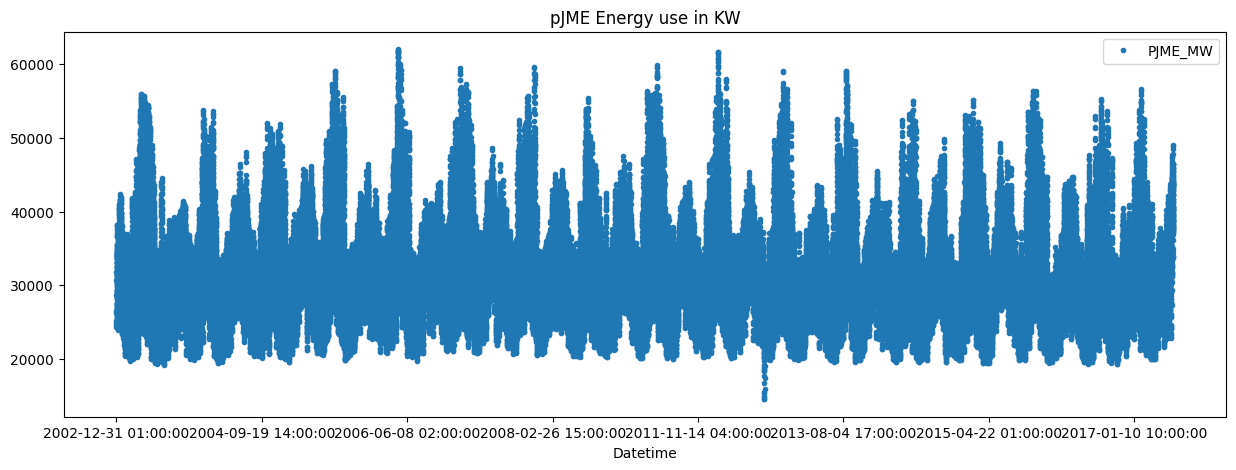

In [9]:
hourly_energy_df.plot(style='.',
                      figsize=(15, 5),
                      color=color_pal[0],
                      title='pJME Energy use in KW')

In [10]:
hourly_energy_df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [11]:
hourly_energy_df.index = pd.to_datetime(hourly_energy_df.index)
hourly_energy_df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


Train/Test Split

In [12]:
train = hourly_energy_df.loc[hourly_energy_df.index < '01-01-2015']
test = hourly_energy_df.loc[hourly_energy_df.index >= '01-01-2015']
train.shape, test.shape

((113926, 1), (31440, 1))

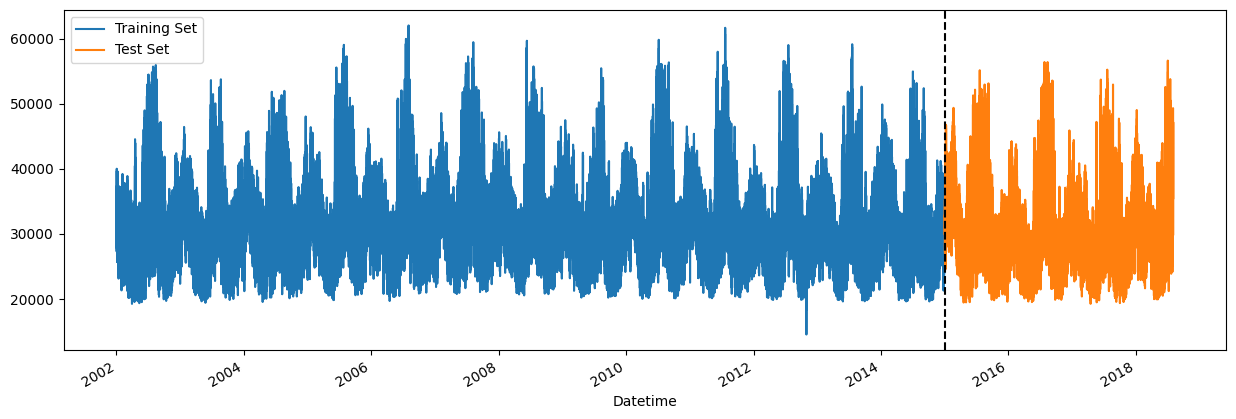

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set")
test.plot(ax=ax, label="Test Set")
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

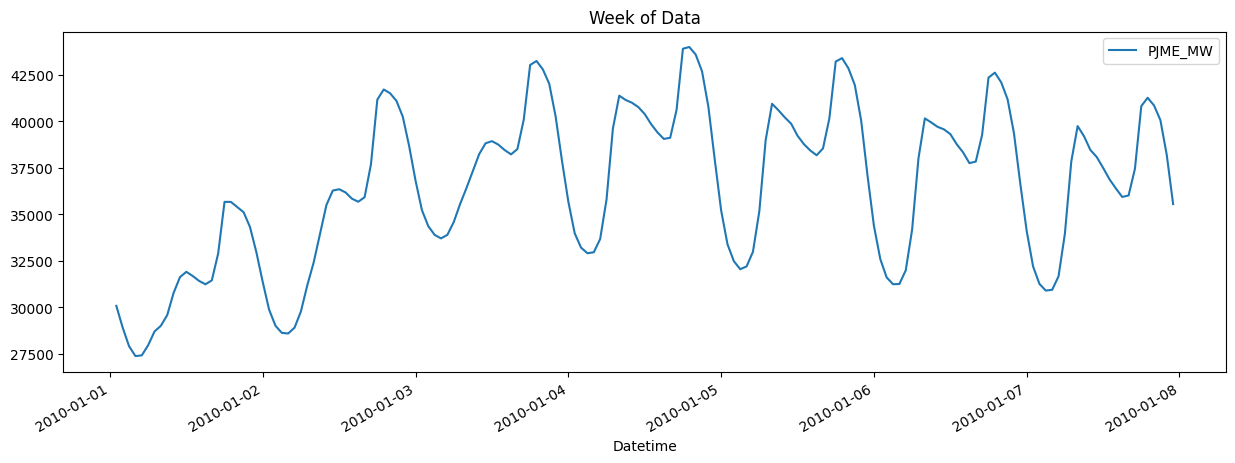

In [14]:
hourly_energy_df.loc[(hourly_energy_df.index > '01-01-2010') & (hourly_energy_df.index < '01-08-2010')] \
  .plot(figsize=(15, 5), title="Week of Data")
plt.show

In [15]:
# Feature creation
def create_features(hourly_energy_df):
  """
    Create time series features based on time series index
  """
  hourly_energy_df = hourly_energy_df.copy()
  hourly_energy_df['hour'] = hourly_energy_df.index.hour
  hourly_energy_df['dayofweek'] = hourly_energy_df.index.day_of_week
  hourly_energy_df['quarter'] = hourly_energy_df.index.quarter
  hourly_energy_df['month'] = hourly_energy_df.index.month
  hourly_energy_df['year'] = hourly_energy_df.index.year
  hourly_energy_df['dayofyear'] = hourly_energy_df.index.dayofyear
  return hourly_energy_df

hourly_energy_df = create_features(hourly_energy_df)

In [16]:
hourly_energy_df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


Visualize feature/targer relationship

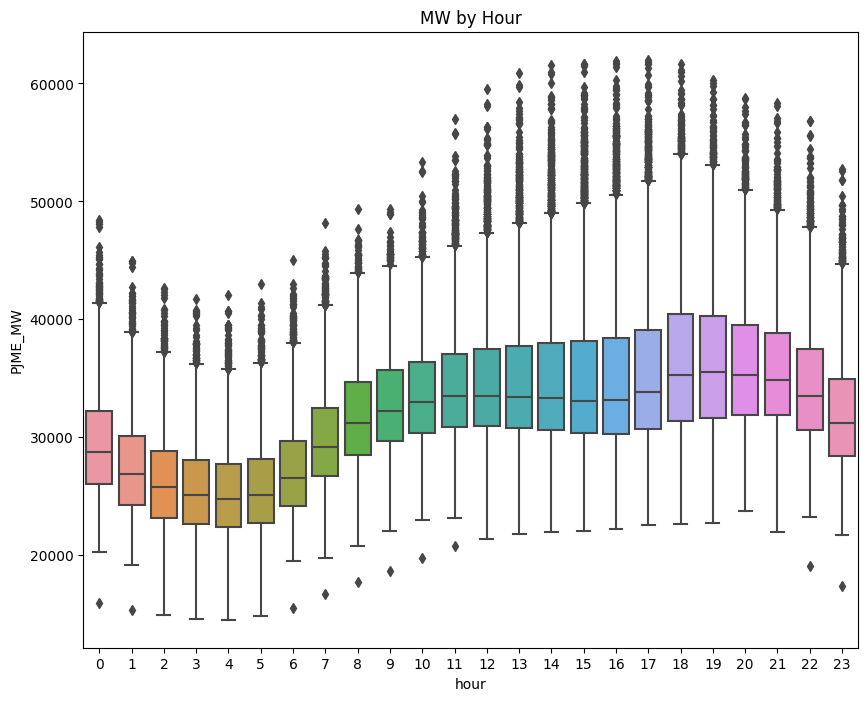

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=hourly_energy_df, x='hour', y='PJME_MW')
ax.set_title("MW by Hour")
plt.show()

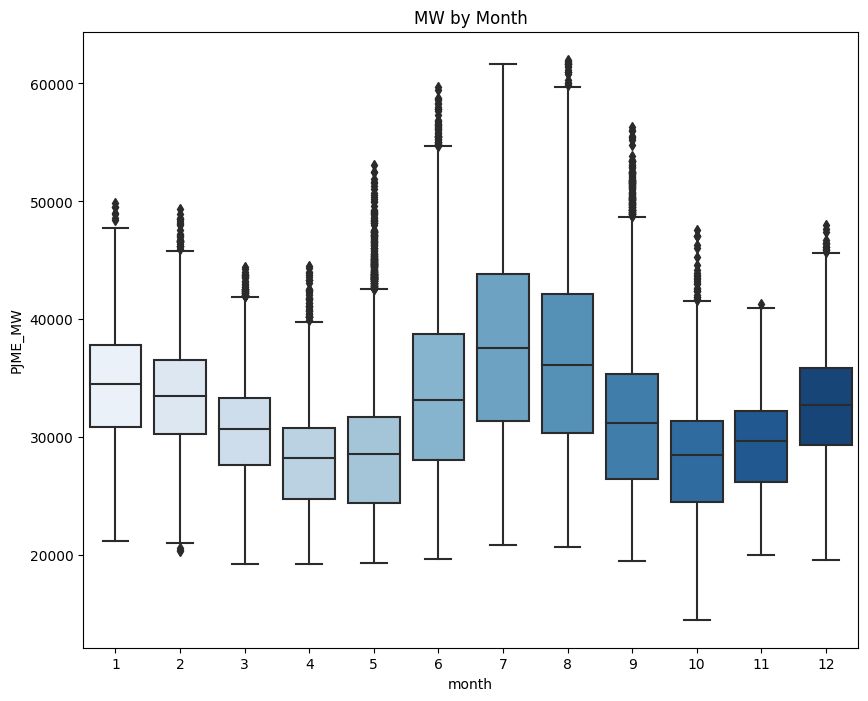

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=hourly_energy_df, x='month', y='PJME_MW', palette="Blues")
ax.set_title("MW by Month")
plt.show()

Model Creation

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
train = create_features(train)
test = create_features(test)

In [21]:
hourly_energy_df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [22]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['PJME_MW']

In [23]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
energy_consumption_model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                                            learning_rate=0.01)
energy_consumption_model.fit(X_train, y_train,
                             eval_set=[(X_train, y_train), (X_test, y_test)],
                             verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

FEATURE IMPORTANCE

In [25]:
energy_cons_feature_important = pd.DataFrame(energy_consumption_model.feature_importances_,
             index=energy_consumption_model.feature_names_in_,
             columns=['importance'])
energy_cons_feature_important

,importance
hour,0.463878
dayofweek,0.162005
quarter,0.028881
month,0.203161
year,0.023824
dayofyear,0.118251


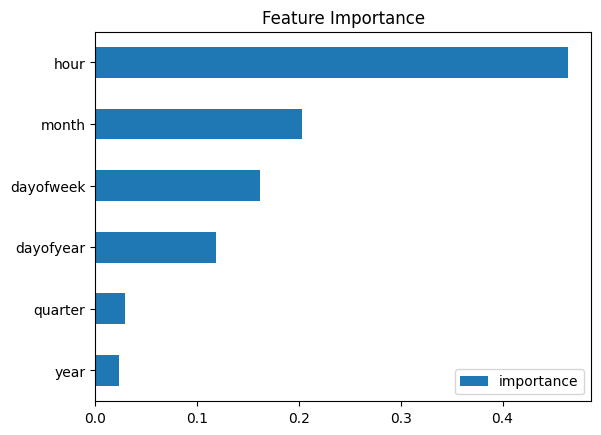

In [26]:
energy_cons_feature_important.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Forecast on Test

In [27]:
test['prediction']=energy_consumption_model.predict(X_test)

In [28]:
hourly_energy_df = hourly_energy_df.merge(test[['prediction']], how="left", left_index=True, right_index=True)

In [29]:
hourly_energy_df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN


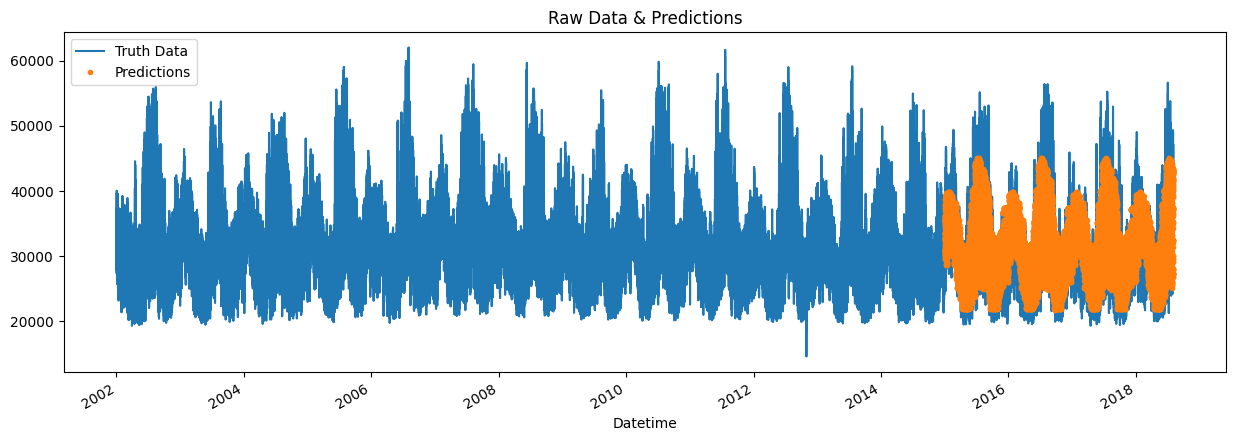

In [30]:
ax = hourly_energy_df[['PJME_MW']].plot(figsize=(15, 5))
hourly_energy_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data & Predictions')
plt.show()

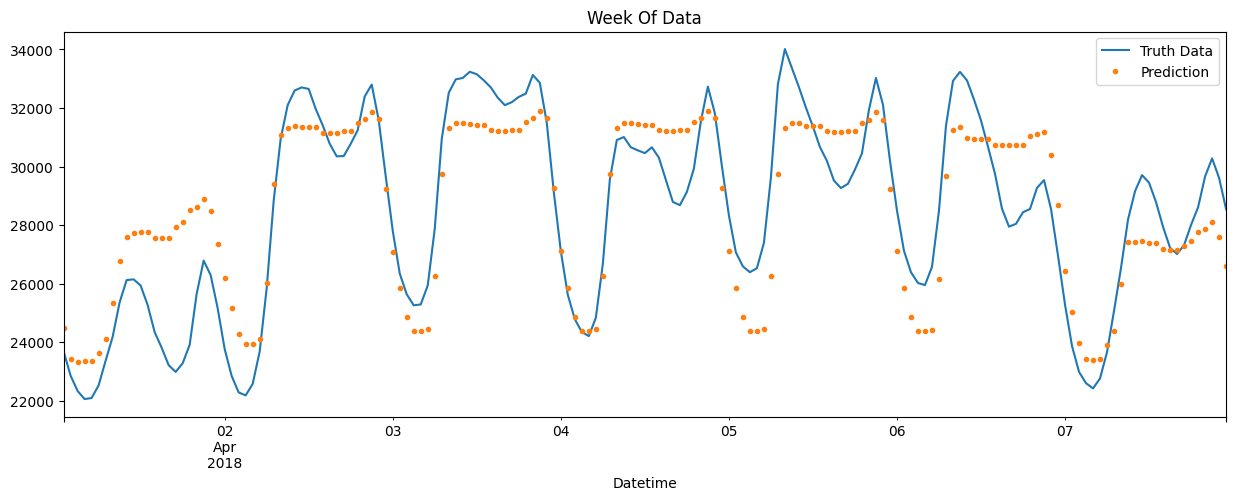

In [31]:
ax = hourly_energy_df.loc[(hourly_energy_df.index > '04-01-2018') & (hourly_energy_df.index < '04-08-2018')]['PJME_MW'] \
  .plot(figsize=(15, 5), title="Week Of Data")
hourly_energy_df.loc[(hourly_energy_df.index > '04-01-2018') & (hourly_energy_df.index < '04-08-2018')]['prediction'] \
  .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [32]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f"RMSE Score on Test Set: {score:0.2f}")

RMSE Score on Test Set: 3741.03


CALCULATE ERROR

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [2]:
test['date'] = test.index.date

NameError: ignored

In [3]:
test.groupby('date')['error']\
  .mean() \
  .sort_values(ascending=False) \
  .head(5)

NameError: ignored

In [4]:
test.groupby('date')['error']\
  .mean() \
  .sort_values(ascending=True) \
  .head(5)

NameError: ignored